# SC1003 GROUP PROJECT

## Imports and Parameters!
#### (cell 1)

In [1]:
# Cell: Imports & Parameters
import csv
import random
import math
from collections import defaultdict, Counter
import statistics

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Configurable parameters
INPUT_CSV = "records.csv"
OUTPUT_CSV = "teams_output.csv"
TEAM_SIZE = 5
MAX_SWAP_ITERS_PER_GROUP = 5000   # local improvement iterations per tutorial group
# penalty weights (soft constraint tuning)
SCHOOL_PENALTY_WEIGHT = 100.0
GENDER_PENALTY_WEIGHT = 100.0
CGPA_PENALTY_WEIGHT = 10.0


### Use of seeds
This makes your program’s “random” results repeatable.

When you use functions like random.shuffle() or random.randint(), they generate different results every time you run the program.
But by setting a seed, you “lock in” the randomness — meaning if you run your program again, you’ll get the exact same random results.

### Why it’s important here
Since the algorithm forms teams randomly with logic, you want to be able to re-run and debug your code with the same results — for fairness, consistency, and testing.

### I/O file names
INPUT_CSV: where your student records are stored (given to you)
OIUTPOUT_CSV: the new file your program will create after forming teams.

### Team size
This defines how many students go into each team.

### Swap iterations
When the algorithm is trying to optimize teams (e.g. swapping members to make teams more balanced/diverse), it doesn’t go on forever.
This parameter limits the number of times it can attempt “swaps” or “improvements” inside each tutorial group.

##### Why?
Without a limit, your code might keep trying forever to find a perfect team combination (which is almost impossible).
This ensures the program stops at a reasonable point — trading off speed vs. quality.

### Penalty weight 
These are “weights” for how much your algorithm “cares” about each type of diversity when forming teams.
- SCHOOL_PENALTY_WEIGHT - How heavily to penalize teams that have too many students from the same school.
- GENDER_PENALTY_WEIGHT - How heavily to penalize teams that have too many students of the same gender.
- CGPA_PENALTY_WEIGHT - How heavily to penalize teams that are unbalanced in academic performance.

##### Why is CGPA lower?
It just means it’s harder to perfectly balance compared to school or gender — so the algorithm gives it a softer weight.

Then the algorithm will first try to fix school/gender imbalance,
and then adjust CGPA as much as possible within that constraint.
So it still cares about CGPA — just not at the cost of breaking diversity in gender/school.

## In short
|Left  |Center|Right|
|:-----|:-----:|----:|
|School diversity|100|Very important — want a mix of backgrounds|
|Gender balance|100|Very important — promote diversity|
|CGPA balance|10|Important, but secondary — avoid extremes, not perfect equality|

## Utility functions (read/write CSV, quartiles, stats)
#### (cell 2)

In [2]:
# Cell: Utilities - CSV IO, quartiles, stats (pure python)
def read_records(filepath):
    records = []
    with open(filepath, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            # normalize keys if necessary (strip)
            rec = {k.strip(): v.strip() for k, v in row.items()}
            # ensure CGPA float
            try:
                rec['CGPA'] = float(rec['CGPA'])
            except:
                # if missing or invalid, set a median placeholder 3.0 (or handle another way)
                rec['CGPA'] = 3.0
            records.append(rec)
    return records

def write_teams(records_with_team, filepath):
    #Define column order
    headers = ["Tutorial Group", "Student ID", "School", "Name", "Gender", "CGPA", "Team Assigned"]
    
    # Open the output file for writing
    with open(filepath, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        
        #Write the column headers first
        writer.writeheader()

        #Write each student record (each dictionary) as one row in the CSV
        for r in records_with_team:
            # ensure ordering
            out = {k: r.get(k, "") for k in headers}
            writer.writerow(out)

def compute_quartile_labels(cgpa_list):
    # Sort CGPAs from low to high
    sorted_vals = sorted(cgpa_list)
    n = len(sorted_vals)
    
    if n == 0:
        return lambda x: 0
        
    def pct_index(p):
        # p in [0,1), return index
        return max(0, min(n-1, int(math.floor(p * n))))
        
    # Find cutoff points for quartiles (25%, 50%, 75%)
    q1 = sorted_vals[pct_index(0.25)]
    q2 = sorted_vals[pct_index(0.5)]
    q3 = sorted_vals[pct_index(0.75)]
    
    #assign a quartile number (0–3) to a given CGPA.
    def label(x):
        if x <= q1:
            return 0
        elif x <= q2:
            return 1
        elif x <= q3:
            return 2
        else:
            return 3
    return label

def mean_std(values):
    if not values:
        return 0.0, 0.0
    if len(values) == 1:
        return values[0], 0.0
    mu = sum(values) / len(values)
    # population std dev (ddof=0) to be consistent
    var = sum((v - mu) ** 2 for v in values) / len(values)
    return mu, math.sqrt(var)


### For read_records(filepath):
Returns a list of dict records. Each dict keys:   
'Tutorial Group','Student ID','Name','School','Gender','CGPA' (CGPA as float)  
#### Results  
rec = {
    "Tutorial Group": "T01",  
    "Student ID": "U1234567A",  
    "Name": "Alice Tan",  
    "School": "SCSE",  
    "Gender": "F",  
    "CGPA": "4.5"  
}  
### For "rec = {k.strip(): v.strip() for k, v in row.items()}" loop statement  
meaning:   
For every key–value pair in the dictionary row,
remove spaces from both key and value using .strip(),
and store the cleaned-up version in a new dictionary called rec

## In short
|Left  |Right|
|:-----|----:|
|for k, v in row.items()|Go through each (key, value) in the row|
|k.strip()|Clean spaces from the key|
|v.strip()|Clean spaces from the value|
|{k.strip(): v.strip() for k, v in row.items()}|Build a new cleaned dictionary|
|rec = ...|Save it as a new variable called "rec"|
  
### For the CGPA part  
to convert the CGPAs from str to int/float
|Left  |Right|
|:-----|----:|
|try:|“Try to run the next line”|
|float(rec['CGPA'])|Convert the CGPA value from text to a float (e.g. "4.5" → 4.5).|  
**I don't think there is a need for except (if they don't have CGPAs or invalid CGPAs), cuz I don't think there will be such data.**  

### For def write_teams(records_with_team, filepath):
records_with_team: list of dicts with final columns including 'Team Assigned'  
Writes CSV with columns in the requested order:  
“Tutorial Group”, “Student ID”, “School”, “Name”, “Gender”, “CGPA”, “Team Assigned”  
|Left  |Right|
|:-----|----:|
|records_with_team|A list of dictionaries — each dictionary represents one student record, including the new "Team Assigned" info.|
|filepath|The name of the output CSV file (eg. "teams_output.csv").|  

##### For "for r in records_with_team:" loop statement  
It’s a safety mechanism to guarantee all columns exist in the right order, and it prevents CSV writing errors when some keys are missing or incomplete.  
1. Only the columns listed in fieldnames are included.
2. If a field is missing in r, it fills it with an empty string ("") instead of crashing.

|Left  |Right|
|:-----|----:|
|{k: r.get(k, "") for k in fieldnames}|Create a new dictionary that includes only the keys from fieldnames.|
|r.get(k, "")|Get the value of key k from record r; if it doesn’t exist, use "".|
|out = ...|Assign that new dictionary to out.|
|writer.writerow(out)|Safely writes it to the CSV file without missing key errors.|  

## In short 
|Left  |Right|
|:-----|----:|
|headers = [...]|Define columns for your output CSV|
|with open(filepath, 'w') as f:|Open file for writing|
|writer = csv.DictWriter(f, fieldnames=headers)|Create CSV writer object|
|writer.writeheader()|Write column titles|  
|for rec in records_with_team:|Loop through each record|  
|writer.writerow(rec)|Write one row per student|  

### For compute_quartile_labels(cgpa_list):
Return a mapping CGPA -> quartile label 0..3.  
We do this deterministically: compute quartile cut points (median of lower/upper) and assign quartiles by comparing CGPA to cut points.  
If many identical values, quartiles may be imbalanced — that's fine.  

##### For def pct_index(p):
We needed to find where the 25th percentile (Q1), 50th percentile (median, Q2), and 75th percentile (Q3) values are inside the sorted CGPA list.  
To do that, we need to convert a percentile (like 0.25) into an index in the sorted list — that’s what pct_index() does.
**Steps**
1. p * n → multiply percentile by number of students (n)
    1. If n = 100,
       + for p = 0.25, p * n = 25
       + for p = 0.5, p * n = 50
3. math.floor(p * n) → round down to an integer index
   + Keeps it valid for indexing (e.g., index 25 instead of 25.7).
3. int(...) → explicitly converts it to an integer (index type).
4. min(n - 1, ...) → ensures the index doesn’t exceed the last valid index (since list indices go from 0 to n - 1).
5. max(0, ...) → ensures it’s not negative (if p = 0.0, you still get index 0).
So it returns a **safe index position** within [0, n-1] corresponding to that percentile.
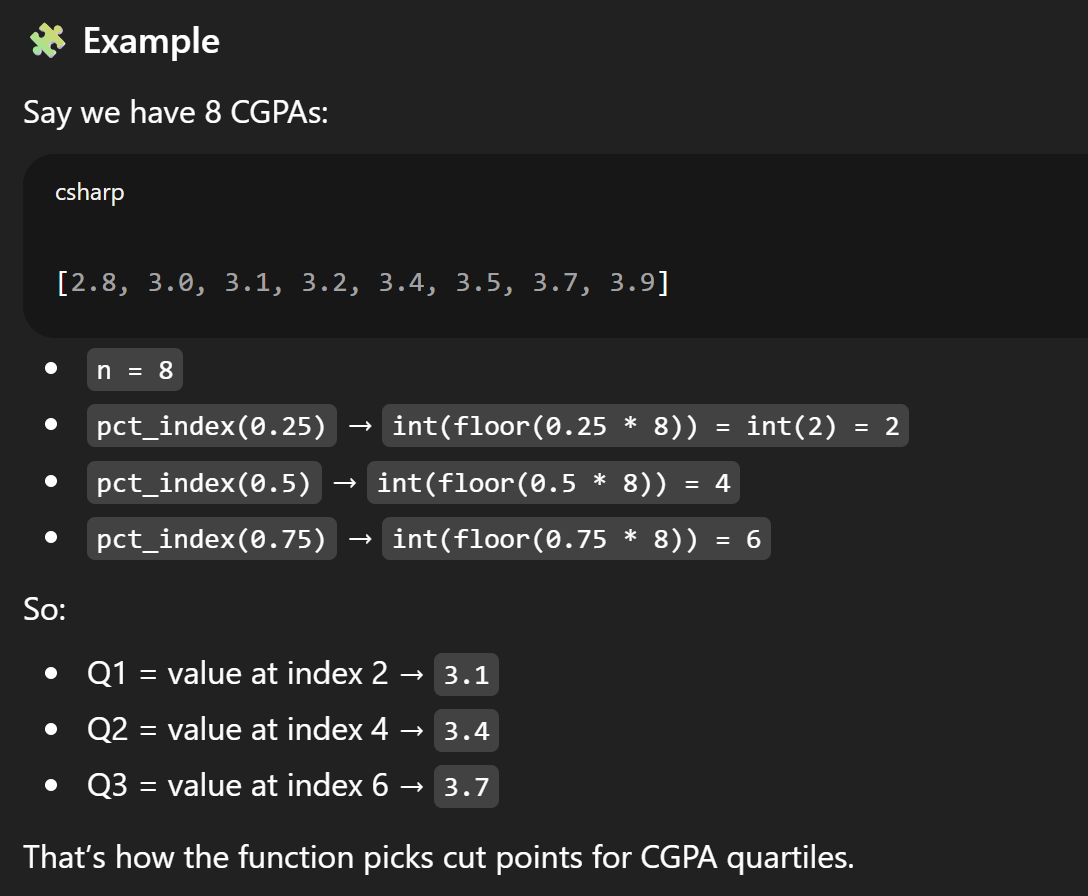

### For def mean_std(values):
+ Check average CGPA of a team or tutorial.
+ Check how balanced CGPAs are
+ **Helps your algorithm ensure academic balance when forming teams.**

## Team size partition helper
#### (cell 3)

In [3]:
# Cell: partition students into team sizes per tutorial (ensures sizes differ by at most 1)
def make_target_sizes(n_students, team_size):
    # We create ceil(n_students/team_size) teams, then distribute remainder so sizes differ by ≤1
    if n_students == 0:
        return []
    n_teams = math.ceil(n_students / team_size)
    base, rem = divmod(n_students, n_teams)  # base size, rem teams get base+1
    sizes = [base + 1 if i < rem else base for i in range(n_teams)]
    return sizes


### For def make_target_sizes(n_students, team_size):
Purpose:
 + All teams have roughly team_size students.
 + If exact division isn’t possible, team sizes differ by at most 1 student.  


## Initial assignment (stratified seeding using school/gender/cgpa-quartile)
#### (cell 4)

In [4]:
# Cell: initial assignment heuristic using buckets (School, Gender, CGPA-Quartile)
def initial_assignment(students, sizes):
    if not students:
        return []

    # Extract all CGPAs from the students into a list and determine quartiles for this tutorial
    cgpas = [s['CGPA'] for s in students]
    qlabel = compute_quartile_labels(cgpas)

    # group students by (school, gender, q)
    buckets = defaultdict(list)
    for s in students:
        key = (s['School'], s['Gender'], qlabel(s['CGPA']))
        buckets[key].append(s)

    # sort bucket keys by descending bucket size to spread large buckets first
    keys_sorted = sorted(buckets.keys(), key=lambda k: len(buckets[k]), reverse=True)

    #Prepare empty teams and capacities
    teams = [[] for _ in sizes]
    caps = sizes[:]   # remaining capacities

    # round-robin assignment from each bucket to the team that currently has; We take each bucket in turn (e.g., all female NBS quartile-3 students).
    # smallest count of that bucket's school/gender and has capacity
    for key in keys_sorted:
        bucket = buckets[key]
        school, gender, _q = key
        while bucket:
            # candidate teams (have capacity); We find all teams that still have space (caps[i] > 0), if there are no available teams, we stop.
            cand_idxs = [i for i, c in enumerate(caps) if c > 0]
            if not cand_idxs:
                break
            # Evaluate which team is best: minimize (count of same school, count of same gender), tie-break by largest cap
            def score(i):
                team = teams[i]
                cnt_school = sum(1 for m in team if m['School'] == school)
                cnt_gender = sum(1 for m in team if m['Gender'] == gender)
                # prefer lower counts and more capacity
                return (cnt_school, cnt_gender, -caps[i])

            #best = index of team with lowest (best) score.
            best = min(cand_idxs, key=score)
            #Add one student from the current bucket to that team.
            teams[best].append(bucket.pop())
            #Reduce that team’s capacity by 1.
            caps[best] -= 1

    # If any students remain (edge cases), place them into teams with capacity or smallest teams
    leftover = []
    # Sometimes, some students remain unassigned — for example, if a bucket wasn’t fully emptied because all teams were full.
    #So we gather all the remaining students into a single list leftover.
    for key in buckets:
        leftover.extend(buckets[key])  # some buckets may be non-empty if loop exited

    # Try to fill any team that still has remaining capacity.
    # If all teams are already full, just put the student into the team with the fewest members — to keep teams balanced.
    for s in leftover:
        placed = False
        for i in range(len(teams)):
            if caps[i] > 0:
                teams[i].append(s); caps[i] -= 1; placed = True; break
        if not placed:
            # place into smallest team
            idx = min(range(len(teams)), key=lambda i: len(teams[i]))
            teams[idx].append(s)
    return teams


### For def initial_assignment(students, sizes):
students: list of dicts (with 'School','Gender','CGPA', etc.)  
sizes: list of target sizes for teams in this tutorial  
returns list of teams (each is a list of student dicts)  

### for keys_sorted = sorted(buckets.keys(), key=lambda k: len(buckets[k]), reverse=True)
This ensures we process big buckets first (for example, if there are 200 SCSE males, we place them first),
so we spread them evenly across teams — otherwise, they might all end up in one team at the end.  

### For def score(i):
it calculates a “score” for each candidate team i:
  + cnt_school: how many people in that team already have the same school → we want this to be low (to promote school diversity)
  + cnt_gender: how many people in that team already have the same gender → we want this to be low (to promote gender balance)
  + -caps[i]: negative because we want teams with more remaining space to be preferred (larger capacity = better)  
So we will choose the team that:
 + Has the fewest people from the same school
 + Has the fewest people of the same gender
 + If tied, has more capacity left

## Penalty function & local improvement (swap-based)
#### (cell 5)

In [5]:
# Cell: penalty & local-improvement swap
def team_penalty(team, group_mean, group_std):
    #see how many students are in this team; if the team is empty (edge case), no penalty.
    n = len(team)
    if n == 0:
        return 0.0
        
    # school majority
    #counts how many members are from each school
    sch_counts = Counter([m['School'] for m in team])
    #gives you the largest count — i.e. how many students come from the most common school in this team.
    top_school_count = sch_counts.most_common(1)[0][1]
    
    majority_threshold = n // 2 + 1  # strict majority > n/2

    #If too many people from the same school (e.g., 3 SCSE in a 4-person team): we calculate a penalty proportional to how many exceed the “safe limit”.
    school_pen = 0.0
    if top_school_count >= majority_threshold:
        school_pen = (top_school_count - (majority_threshold - 1)) * SCHOOL_PENALTY_WEIGHT

    # gender majority
    #Works exactly the same as school penalty, but for gender
    gen_counts = Counter([m['Gender'] for m in team])
    top_gender_count = gen_counts.most_common(1)[0][1]
    gender_pen = 0.0
    if top_gender_count >= majority_threshold:
        gender_pen = (top_gender_count - (majority_threshold - 1)) * GENDER_PENALTY_WEIGHT

    # CGPA deviation penalty
    #Find the average CGPA in the team.
    cgpas = [m['CGPA'] for m in team]
    team_mean = sum(cgpas) / len(cgpas)
    
    #Compute how “far” this team’s average CGPA is from the overall group’s average, measured in standard deviations (z-score).
    #If the overall group’s CGPAs don’t vary (group_std = 0), then difference = 0.
    if group_std > 0:
        z = abs(team_mean - group_mean) / group_std
    else:
        z = 0.0
        
    #Convert the z-score difference into a penalty weighted by a constant.
    cgpa_pen = z * CGPA_PENALTY_WEIGHT

    return school_pen + gender_pen + cgpa_pen

#So this gives you one single “score” representing how balanced the entire tutorial group’s team allocation is.
#The smaller this number → the more diverse and fair your grouping is.
def total_penalty(teams, group_mean, group_std):
    return sum(team_penalty(t, group_mean, group_std) for t in teams)

def local_improvement_swaps(teams, group_mean, group_std, max_iters=2000):
    current_pen = total_penalty(teams, group_mean, group_std) #current total penalty of all teams.
    iters = 0 #how many iterations we’ve done.
    no_improve_count = 0 #how many swaps we’ve tried without improvement.
    
    while iters < max_iters and no_improve_count < 500:
        iters += 1
        # pick two distinct teams
        
        if len(teams) < 2:
            break #If there’s only 1 team, we can’t swap anything.
            
        #Randomly pick two different teams.
        i, j = random.sample(range(len(teams)), 2)
        if not teams[i] or not teams[j]:
            continue #Skip if one of the teams is empty (shouldn’t normally happen, but just in case)
            
        a = random.randrange(len(teams[i]))
        b = random.randrange(len(teams[j])) #Randomly choose one student index from team i and one from team j, to be swapped
        
        # Calculate how “bad” (penalty) the two teams are before the swap.
        before = team_penalty(teams[i], group_mean, group_std) + team_penalty(teams[j], group_mean, group_std)
        
        # swap
        teams[i][a], teams[j][b] = teams[j][b], teams[i][a]
        
        #Now calculate how “bad” they are after the swap.
        after = team_penalty(teams[i], group_mean, group_std) + team_penalty(teams[j], group_mean, group_std)

        #If the new configuration’s penalty is smaller (i.e. better diversity): Keep the swap, Update the total penalty, Reset the “no improvement” counter
        if after < before - 1e-9:
            current_pen += (after - before)
            no_improve_count = 0
        else:
            # revert
            teams[i][a], teams[j][b] = teams[j][b], teams[i][a]
            no_improve_count += 1 #Increment “no improvement” count.
    return teams, current_pen


### For def team_penalty(team, group_mean, group_std):
Purpose: 
  + Evaluates how “good” or “bad” (fair/unfair) a team formation is using a penalty score.
  + Improves the teams step-by-step by swapping students between teams if that reduces unfairness.  

Soft-penalty for a single team:
 + big penalty if a majority of team from same School
 + big penalty if a majority of same Gender
 + moderate penalty for deviation of team mean CGPA from group mean (z-score * weight)  

Returns float penalty

### For def local_improvement_swaps(teams, group_mean, group_std, max_iters=2000):
Randomized pairwise swap improvement:
+ Randomly pick two distinct teams and indices, attempt swap, accept if local penalty decreases
+ Repeat until max_iters without improvement
  
**This function tries to improve your team assignments by making random swaps between teams — but only keeps swaps that reduce the overall penalty.**


## Form teams for one tutorial group (full pipeline)
#### (cell 6)

In [6]:
# Cell: form teams for one tutorial
def form_teams_for_tutorial(students, team_size=TEAM_SIZE, max_swap_iters=MAX_SWAP_ITERS_PER_GROUP):
    
    #counts how many students are in this tutorial group
    n = len(students)

    #Determine how many teams to create and their sizes
    sizes = make_target_sizes(n, team_size)

    #Make an initial assignment
    teams = initial_assignment(students, sizes)
    
    # compute group CGPA stats
    cgpas = [s['CGPA'] for s in students] #Extract all CGPA values for this tutorial group.
    group_mean, group_std = mean_std(cgpas) #To get average CGPA of all students in this tutorial group & standard deviation — how spread out the CGPAs are.
    
    # Improve the initial allocation using swaps
    teams, final_pen = local_improvement_swaps(teams, group_mean, group_std, max_iters=max_swap_iters)

    #returns a tuple of results for each tutorial group
    return teams, final_pen, group_mean, group_std


### For def form_teams_for_tutorial(students, team_size=TEAM_SIZE, max_swap_iters=MAX_SWAP_ITERS_PER_GROUP):
Purpose: 
 + Figures out how many teams are needed (of 4–5 students each)
 + Makes an initial, balanced assignment of students
 + Improves the balance through swap optimization
 + Returns the final result

**Return a tuple of results for this tutorial group:**
1. **teams — list of final teams (each team = list of student dicts)**
2. **final_pen — final diversity penalty after improvement**
3. **group_mean — mean CGPA of the tutorial group**
4. **group_std — standard deviation of CGPA of the group**


## Full run over all tutorial groups & write output CSV
#### (cell 7)

In [7]:
# Cell: run for all tutorials & write output
records = read_records("records.csv") #to load student data from the input CSV

# Group by tutorial group (use a dict: tutorial -> list of student dicts)
groups = defaultdict(list)
for r in records:
    groups[r['Tutorial Group']].append(r)

final_records = []  # each record will include 'Team Assigned'
group_summaries = []  # store per-tutorial summary for evaluation & reporting
total_penalty_all = 0.0 # cumulative diversity penalty

#tg = tutorial group name ('T01', 'T02', etc.); students = list of student dictionaries in that group; sorted() ensures they’re processed in alphabetical order (nice and tidy).
for tg, students in sorted(groups.items()):
    teams, pen, group_mean, group_std = form_teams_for_tutorial(students)
    total_penalty_all += pen #total up the total penalty
     
    # flatten teams into final_records
    for tidx, team in enumerate(teams, start=1):
        team_id = f"{tg}_T{tidx}"
        for m in team:
            rec = {
                "Tutorial Group": tg,
                "Student ID": m['Student ID'],
                "School": m['School'],
                "Name": m['Name'],
                "Gender": m['Gender'],
                "CGPA": m['CGPA'],
                "Team Assigned": team_id
            }
            final_records.append(rec)
            
    # compute violation counts for this tutorial to track: How many teams are violating rules, How diverse each team is, Average CGPA of each team
    violating = 0
    team_diversities = []
    team_cgpa_means = []
    for team in teams:
        n = len(team)
        if n == 0:
            continue #skip any possible empty list

        #Counts how many members belong to each school/gender.
        #If more than half are from the same school or gender, mark as “violating”.
        #Adds 1 to the count of violating teams.
        top_school_count = Counter([m['School'] for m in team]).most_common(1)[0][1]
        top_gender_count = Counter([m['Gender'] for m in team]).most_common(1)[0][1]
        if top_school_count > n/2 or top_gender_count > n/2:
            violating += 1
            
        # diversity measure (entropy over schools)
        schools = [m['School'] for m in team]
        counts = Counter(schools)
        # Shannon entropy base 2
        entropy = 0.0
        for c in counts.values():
            p = c / n
            entropy -= p * (math.log(p, 2) if p > 0 else 0)
        team_diversities.append(entropy)
        #Higher entropy = more diverse (schools evenly represented), Lower entropy = dominated by one school
        
        cgpa_mean = sum(m['CGPA'] for m in team) / n
        team_cgpa_means.append(cgpa_mean) #Takes the average CGPA within that team

    #Stores all tutorial-level data for reporting later
    group_summaries.append({
        "Tutorial Group": tg,
        "Students": len(students),
        "Teams": len(teams),
        "Violating Teams": violating,
        "Group Penalty": pen,
        "Avg Team Entropy": (sum(team_diversities)/len(team_diversities)) if team_diversities else 0.0,
        "Avg Team CGPA Mean": (sum(team_cgpa_means)/len(team_cgpa_means)) if team_cgpa_means else 0.0,
        "Group CGPA Mean": group_mean,
        "Group CGPA Std": group_std
    })

# Write output CSV
write_teams(final_records, OUTPUT_CSV)
#Calls your earlier helper function write_teams() to save all students with their team assignments, & prints a summary message (eg. Wrote 1200 student-team records to output.csv)
print(f"Wrote {len(final_records)} student-team records to {OUTPUT_CSV}")

print(f"Total penalty across all groups: {total_penalty_all:.2f}")

# Print summary of first few tutorial groups
for s in sorted(group_summaries, key=lambda x: x["Tutorial Group"])[:10]:
    print(s)
#Shows how balanced things are overall (lower total penalty = more balanced)
#Then prints summaries of the first 10 tutorial groups for inspection

Wrote 6000 student-team records to teams_output.csv
Total penalty across all groups: 122749.33
{'Tutorial Group': 'G-1', 'Students': 50, 'Teams': 10, 'Violating Teams': 10, 'Group Penalty': 1001.3032427554988, 'Avg Team Entropy': 2.1619280948873625, 'Avg Team CGPA Mean': 4.095599999999999, 'Group CGPA Mean': 4.0956, 'Group CGPA Std': 0.12277068053896256}
{'Tutorial Group': 'G-10', 'Students': 50, 'Teams': 10, 'Violating Teams': 10, 'Group Penalty': 1000.6552975829102, 'Avg Team Entropy': 2.1619280948873625, 'Avg Team CGPA Mean': 4.118, 'Group CGPA Mean': 4.118, 'Group CGPA Std': 0.1220819396962548}
{'Tutorial Group': 'G-100', 'Students': 50, 'Teams': 10, 'Violating Teams': 10, 'Group Penalty': 1001.0156517159475, 'Avg Team Entropy': 2.1619280948873625, 'Avg Team CGPA Mean': 4.0942, 'Group CGPA Mean': 4.0942, 'Group CGPA Std': 0.11027402232620336}
{'Tutorial Group': 'G-101', 'Students': 50, 'Teams': 10, 'Violating Teams': 10, 'Group Penalty': 1000.5723638070324, 'Avg Team Entropy': 2.16

### Purpose of this cell:
 + Reads all students from the CSV file
 + Groups them by tutorial group
 + For each tutorial, calls your form_teams_for_tutorial() function
 + Collects results (team assignments + summary stats)
 + Writes everything into one output CSV file

**So this is the main execution cell — the “run everything” part.**

### For for tidx, team in enumerate(teams, start=1):
 + Goes through each team in the tutorial
 + Assigns it a readable ID, like:
   + T01_T1, T01_T2, etc.
 + Then, for each student m in that team:
   + Builds a new record that adds "Team Assigned" to their info
   + Appends it into final_records (for the output CSV)

**So now there isd one big list with every student from every tutorial and their assigned team.**

## Pseudocode
1. **Read records.csv into a list of student dictionaries.**
2. **Group students by 'Tutorial Group' => tutorial -> [students].**
3. **For each tutorial:**
   1. **Compute number of teams: n_teams = ceil(n_students / TEAM_SIZE).**
   2. **Compute target team sizes so sizes differ by at most 1.**
   3. **Compute CGPA quartiles for students in this tutorial.**
   4. **Bucket students by (School, Gender, CGPA-quartile).**
   5. **Initial assignment: for each bucket (largest first) round-robin assign members to teams, choosing the team that currently minimizes count of same school & gender and has capacity.**
   6. **Local improvement: repeatedly pick two random teams and attempt to swap one member between them; accept swap if it reduces the sum of penalties for those two teams. Penalty = large penalty for school majority + large penalty for gender majority + moderate penalty for team CGPA mean deviation from group mean.**
   7. **When no improvement or iteration limit reached, finalize teams for the tutorial.**
4. **Flatten all teams, add 'Team Assigned' column, and write to output CSV.**